# Anexo Clase 1

## Visualización Avanzada

In [1]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

### Subplots y leyendas ad-hoc

In [2]:
# g = nx.karate_club_graph()
g = nx.erdos_renyi_graph(27, 0.1)
nx.set_node_attributes(g, dict(g.degree()), "grado")

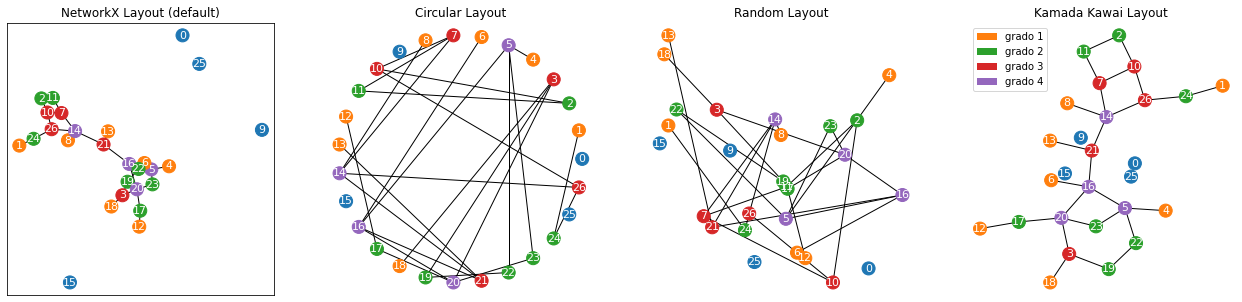

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(22, 5))
kwargs = {
    "node_color": [f"C{g.nodes[n]['grado']}" for n in g],
    "with_labels": True,
    "font_size": 11,
    "font_color": "white",
    "node_size": 170,
}
nx.draw_networkx(g, ax=ax[0], **kwargs)
ax[0].title.set_text("NetworkX Layout (default)")
nx.draw_circular(g, ax=ax[1], **kwargs)
ax[1].title.set_text("Circular Layout")
nx.draw_random(g, ax=ax[2], **kwargs)
ax[2].title.set_text("Random Layout")
nx.draw_kamada_kawai(g, ax=ax[3], **kwargs)
ax[3].title.set_text("Kamada Kawai Layout")
# Agrega una leyenda explicativa
plt.legend(
    handles=[
        mpl.patches.Patch(facecolor=f"C{i}", label=f"grado {i}")
        for i in range(1, max(dict(g.degree()).values()) + 1)
    ]
)

## 

### Layouts alternativos: recta y grilla

Desmitificando: un _layout_ es una función que asigna coordenadas (x, y) a cada nodo de un grafo.

In [4]:
PRIMOS = (2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37)

def divisor_graph(start, end):
    g = nx.DiGraph()
    g.add_nodes_from(range(start, end + 1))
    for n in range(start, end + 1):
        for p in PRIMOS:
            if n % p == 0:
                g.add_edge(n, n // p, ratio=p)
    return g


def line_layout(G):
    return {n: [n, 0] for n in G}

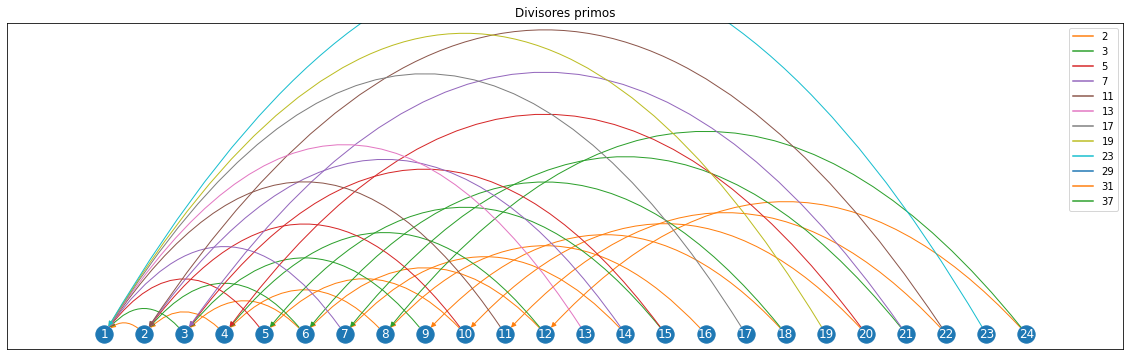

In [5]:
from matplotlib.lines import Line2D
plt.figure(figsize=(20, 6))

g = divisor_graph(1, 24)
pos = line_layout(g)
nx.draw_networkx_nodes(
    g,
    pos=pos,
)
nx.draw_networkx_labels(g, pos, font_color="white")
for i, r in enumerate(PRIMOS, 1):
    edgelist = [e for e in g.edges() if g.edges[e]["ratio"] == r]
    ratios = [g.edges[e]["ratio"] for e in edgelist]
    nx.draw_networkx_edges(
        g,
        pos,
        edgelist=edgelist,
        connectionstyle=f"arc3,rad={(i * 0.05)**0.2}",
        edge_color=f"C{i}"
    )
lines = [Line2D([0], [0], color=f"C{i}") for i, _ in enumerate(PRIMOS, 1)]
plt.legend(lines, PRIMOS)
plt.title("Divisores primos")
plt.show()

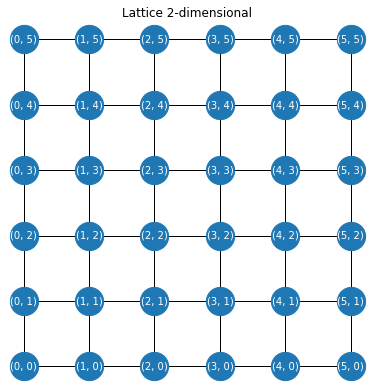

In [6]:
grilla = nx.lattice.grid_graph((6, 6))
plt.figure(figsize=(5, 5))
nx.draw(
    grilla,
    pos={n: n for n in grilla},  # En un "lattice" 2D, el identificador único de cada nodo, es su propia posición en el "layout"!
    with_labels=True,
    node_size=800,
    font_size=10,
    font_color="white"
)
plt.title("Lattice 2-dimensional")
plt.show()

## Generando grafos con datos silvestres
Buscaremos generar 2 datasets, uno de aeropuertos (nodos) y otro de rutas aéreas (aristas) para generar y visualizar el grafo que forman. Para mejorar la visualización, buscaremos también los polígonos que representan las fronteras provinciales. La data será tomada del Portal Nacional de Datos Abiertos, https://datos.gob.ar/.

**Nota**: Todo el trabajo de descarga de datasets que viene a continuación se puede realizar a mano explorando el portal de datos, pero a la larga, conviene aprender a manipular programáticamente estas [APIs](https://es.wikipedia.org/wiki/API).

### 1: Conseguir datasets

In [7]:
import requests  # https://docs.python-requests.org/en/master/
import json

In [8]:
# https://datos.gob.ar/acerca/ckan
# https://datos.transporte.gob.ar/dataset/aterrizajes-y-despegues-registrados-por-eana
res = requests.get("http://datos.gob.ar/api/3/action/package_list")

Algunos atributos de interés de la res(puesta):

In [9]:
print(
    res.url,
    res.status_code,
    res.headers["Content-Type"],
    res.encoding,
    res.text[:100],  # Primeros 100 caracteres del texto contenido
    sep="\n"
)

https://datos.gob.ar/api/3/action/package_list
200
application/json;charset=utf-8
utf-8
{"help": "https://datos.gob.ar/api/3/action/help_show?name=package_list", "success": true, "result":


El contenido es de tipo "json", así que podemos usar el método `res.json` para recuperar el contenido estructurado.
En los [códigos de estado HTTP](https://es.wikipedia.org/wiki/Anexo:C%C3%B3digos_de_estado_HTTP), 200 signifca "OK":

In [10]:
if res.status_code == 200:
    payload = res.json()
    print(payload.keys())
else:
    print("Auch")

dict_keys(['help', 'success', 'result'])


In [11]:
if payload["success"]:
    datasets = payload["result"]

In [12]:
datasets[:10]

['aaip-reclamos-sobre-solicitudes-acceso-informacion-publica',
 'aaip-solicitudes-acceso-informacion-publica',
 'acumar-agentes-contaminantes-cuenca-matanza-riachuelo',
 'acumar-avance-obras-agua-cloaca',
 'acumar-denuncias-recibidas-por-centro-atencion-acumar-2011-2017',
 'acumar-establecimientos-empadronados-cuenca-matanza-riachuelo-2010-2018',
 'acumar-establecimientos-reconvertidos-cuenca-matanza-riachuelo',
 'acumar-establecimientos-seguimiento-particular-cuenca-matanza-riachuelo',
 'acumar-estaciones-medicion-cuenca-matanza-riachuelo',
 'acumar-indicador-ndeg-2---indice-calidad-agua-superficial-ica---acumar']

In [13]:
[
    d for d in datasets
    if any(
        palabra in d for palabra in ["aterrizaje", "despegue", "vuelo", "aeropuerto", "provincias"]
    )]

['salud-vuelos-aerolineas-argentinas---covid-19',
 'salud-vuelos-traslado-vacunas-contra-covid-19-adquiridas-por-argentina',
 'seguridad-estadisticas-criminales-republica-argentina-por-provincias-departamentos',
 'transporte-aeropuertos',
 'transporte-aterrizajes-despegues-registrados-por-empresa-argentina-navegacion-aerea-eana',
 'transporte-lista-aeropuertos',
 'transporte-predios-aeropuertos']

In [14]:
res = requests.get(
    "http://datos.gob.ar/api/3/action/package_show",
    params={"id": "transporte-aterrizajes-despegues-registrados-por-empresa-argentina-navegacion-aerea-eana"}
)

In [15]:
if res.status_code == 200:
    payload = res.json()
    if payload["success"]:
        package = payload["result"]

Examinando a mano el contenido de `package`, se ve lo que nos interesa son los "resources", que contiene metada de los datasets disponibles

In [16]:
dataset_urls = {r["name"].split(" ")[-1]: r["url"] for r in package["resources"]}

In [17]:
dataset_urls

{'2014': 'https://datos.transporte.gob.ar/dataset/344daeec-86f9-44c1-b635-b3193b56f5f8/resource/32d20ed8-e52d-433e-b22c-bfe14983456a/download/aterrizajes-y-despegues-registrados-por-eana-2014.csv',
 '2015': 'https://datos.transporte.gob.ar/dataset/344daeec-86f9-44c1-b635-b3193b56f5f8/resource/d8d31d79-8645-41dd-b0a0-f0531eba3520/download/aterrizajes-y-despegues-registrados-por-eana-2015.csv',
 '2016': 'https://datos.transporte.gob.ar/dataset/344daeec-86f9-44c1-b635-b3193b56f5f8/resource/724c9a48-758a-4a44-9baa-44659a5055d6/download/aterrizajes-y-despegues-registrados-por-eana-2016.csv',
 '2017': 'https://datos.transporte.gob.ar/dataset/344daeec-86f9-44c1-b635-b3193b56f5f8/resource/2a31fb0e-8d71-4575-b78c-288dc77abe03/download/aterrizajes-y-despegues-registrados-por-eana-2017.csv',
 '2018': 'https://datos.transporte.gob.ar/dataset/344daeec-86f9-44c1-b635-b3193b56f5f8/resource/913a7aa8-40ff-40cc-8e09-19175e6e20f6/download/aterrizajes-y-despegues-registrados-por-eana-2018.csv',
 '2019': '

Sumamos datasets de aeropuertos y polígonos de provincias

In [18]:
res = requests.get(
    "http://datos.gob.ar/api/3/action/package_show",
    params={"id": "transporte-lista-aeropuertos"}
)

if res.status_code == 200:
    payload = res.json()
    if payload["success"]:
        package = payload["result"]
        dataset_urls["aeropuertos"] = package["resources"][0]["url"]
else:
    print("Auch")

In [19]:
res = requests.get(
    "http://datos.gob.ar/api/3/action/package_show",
    params={"id": "ign-unidades-territoriales"}
)

poligonos = {
    r["name"]: r["url"]
    for r in res.json()["result"]["resources"]
    if r["format"] == "ZIP"  # Hay CSVs y PDFs, pero nos interesa el ZIP que incluye los polígonos
}

dataset_urls["provincias"] = poligonos["Provincias"]

In [21]:
def download_url(url, relative_dir=".", chunk_size=128):
    import os
    r = requests.get(url, stream=True)
    save_path = os.path.join(relative_dir, url.split("/")[-1])
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

Seteando `DOWNLOAD_DATASETS=True`, bajará los CSVs de interés:

In [22]:
DOWNLOAD_DATASETS=False
if DOWNLOAD_DATASETS:
    for nombre in ["2021", "aeropuertos", "provincias"]:
        url = dataset_urls[nombre]
        print(f"Descargando {url}")
        download_url(url, "data")

### 2: Analizar y limpiar datos

Al final de esta sección, guardaremos los CSVs que representan nuestros listados de nodos (aeropuertos) y aristas (rutas) para representar como grafo.
Las rutinas de analisis y limpieza explicadas sucintamente a continuación son _fundamentales_ para obtener representaciones claras y de calidad. ¡No las desprecien!

In [23]:
import pandas as pd

Conviene inspeccionar los archivos de antemano para entender el formato. En este casom notamos que el separador de campos en `aeropuertos-detalle.csv` es `;` en lugar de `,`

In [24]:
nodes = pd.read_csv("aeropuertos_detalle.csv", sep=";")
edges = pd.read_csv("aterrizajes-y-despegues-2021.csv")

Examino

In [25]:
nodes.head(5)

,local,oaci,iata,tipo,denominacion,coordenadas,latitud,longitud,elev,uom_elev,...,condicion,control,region,fir,uso,trafico,sna,concesionado,provincia,inhab
0,ACB,NaN,NaN,Aeródromo,CORONEL BOGADO/AGROSERVICIOS,"33°16'20""S 60°34'14""W",-60.57066,-33.27226,44.0,Metros,...,PRIVADO,NOCONTROL,RACE,SAEF,AEROAPP,Nacional,NO,NO,SANTA FÉ,NO
1,ACH,NaN,NaN,Aeródromo,GENERAL ACHA,"37°24' 6""S 64°36'49""W",-64.61351,-37.40164,277.0,Metros,...,PUBLICO,NOCONTROL,RACE,SAEF,CIVIL,Nacional,NO,NO,LA PAMPA,NO
2,ACM,NaN,NaN,Aeródromo,ARRECIFES/LA CURA MALAL,"34° 4'33""S 60° 8'30""W",-60.14170,-34.07574,37.0,Metros,...,PRIVADO,NOCONTROL,RACE,SAEF,CIVIL,Nacional,NO,NO,BUENOS AIRES,NO
3,ADO,SAWD,PUD,Aeródromo,PUERTO DESEADO,"47°44' 6""S 65°54'15""W",-65.90410,-47.73511,82.0,Metros,...,PUBLICO,AERADIO,RASU,SAVF,CIVIL,Nacional,NO,NO,SANTA CRUZ,NO
4,ADT,NaN,NaN,Aeródromo,BANDERA/AGROSERVICIOS DOÑA TERESA,"28°51'19""S 62°15'53""W",-62.26462,-28.85541,75.0,Metros,...,PRIVADO,NOCONTROL,RANO,SACF,AEROAPP,Nacional,NO,NO,SANTIAGO DEL ESTERO,NO


In [26]:
edges.head(5)

,Fecha,Hora,Clase de Vuelo,Clasificación Vuelo,Tipo de Movimiento,Origen OACI,Destino OACI,Aerolinea Nombre,Aeronave
0,01/01/2021,0,Regular,Internacional,Aterrizaje,MPTO,SAEZ,Copa Airlines,BOEING B-737
1,01/01/2021,2,Regular,Internacional,Despegue,SAEZ,MPTO,Copa Airlines,BOEING B-737
2,01/01/2021,3,Regular,Internacional,Aterrizaje,SBGR,SAEZ,Qatar Airways,BOEING B-777
3,01/01/2021,4,Regular,Cabotaje,Despegue,SAEZ,SAWC,Aerolíneas Argentinas,BOEING B-737
4,01/01/2021,5,Regular,Internacional,Despegue,SAEZ,SEQM,Qatar Airways,BOEING B-777


¿Hay muchos nulos?

In [27]:
nodes.isna().mean().round(3)

local            0.000
oaci             0.821
iata             0.870
tipo             0.000
denominacion     0.000
coordenadas      0.000
latitud          0.000
longitud         0.000
elev             0.000
uom_elev         0.000
ref              0.014
distancia_ref    0.007
direccion_ref    0.020
condicion        0.000
control          0.000
region           0.000
fir              0.000
uso              0.322
trafico          0.000
sna              0.000
concesionado     0.000
provincia        0.000
inhab            0.000
dtype: float64

In [28]:
edges.isna().mean().round(3)

Fecha                  0.000
Hora                   0.000
Clase de Vuelo         0.000
Clasificación Vuelo    0.017
Tipo de Movimiento     0.000
Origen OACI            0.009
Destino OACI           0.009
Aerolinea Nombre       0.455
Aeronave               0.000
dtype: float64

1. El identificador "OACI" parece estar presente en ambos datasets. ¿Será un buen identificador único de los nodos?
2. Además: ¿Qué quiere decir "Tipo de Movimiento"? ¿No debería haber exactamente un "Aterrizaje" y un "Despegue" por vuelo?

In [29]:
nodos_oaci = nodes.oaci.unique()

In [30]:
edges["Origen Existe"] = edges["Origen OACI"].isin(nodos_oaci)
edges["Destino Existe"] = edges["Destino OACI"].isin(nodos_oaci)

In [31]:
edges.groupby(["Origen Existe", "Destino Existe"]).apply(len)

Origen Existe  Destino Existe
False          True               2813
True           False              3036
               True              23502
dtype: int64

¿Será que si el aeropuerto de origen (resp. destino) no es OACI el despegue (resp. aterrizaje) no se registra?

In [32]:
edges.groupby(["Origen Existe", "Destino Existe", "Tipo de Movimiento"]).apply(len)

Origen Existe  Destino Existe  Tipo de Movimiento
False          True            Aterrizaje             2813
True           False           Despegue               3036
               True            Aterrizaje            10997
                               Despegue              12505
dtype: int64

¡Eureka! Aún así, es curioso que los números de aterrizajes y despegue para los vuelos con origen y destino OACI válido no coincidan.
Pero primero: ¿De dónde salen los ~6K vuelos de aeropuertos no-OACI?

In [33]:
vuelos = edges[~edges["Origen Existe"]].groupby("Origen OACI").apply(len).sort_values(ascending=False)
vuelos[:10]

Origen OACI
SULS       204
SCEL       188
SUMU       171
SBGR       150
KMIA       139
SGAS       129
MPTO        84
AR-0019     78
AR-0175     73
SPJC        70
dtype: int64

- [SULS](https://en.wikipedia.org/wiki/Capit%C3%A1n_de_Corbeta_Carlos_A._Curbelo_International_Airport) es el aeropuerto de Punta del Este, Uruguay,
- [SCEL](https://en.wikipedia.org/wiki/Arturo_Merino_Ben%C3%ADtez_International_Airport) es el de Santiago, Chile.

¡Son destinos OACI internacionales! Mirando algunos códigos de la forma "AR-XXXX", vemos que también son aeropuertos registrados con la OACI ([Organización de Aviación Civil Internacional](https://es.wikipedia.org/wiki/Organizaci%C3%B3n_de_Aviaci%C3%B3n_Civil_Internacional)), pero que no tienen su identificador cpte. en la lista de datos.gob.ar. Por ejemplo, "AR-0019" es el aeropuerto "13 De Diciembre", en Comodoro Rivadavia:

- en este [mapa aeroportuario](https://applications.icao.int/airport-map/) de la OACI 
- en [METAR-TAF](https://metar-taf.com/AR-0019) (portal con reportes meteorológicos de aeropuertos)
- en [AeroInside](https://www.aeroinside.com/airport/ar-0019/comodoro-rivadavia-13-de-diciembre-airport) (base de datos de aviación internacional)

Pero en el dataset de aeropuertos no tienen su identificador:

In [34]:
nodes[nodes["denominacion"].str.lower().str.contains("diciembre")]

,local,oaci,iata,tipo,denominacion,coordenadas,latitud,longitud,elev,uom_elev,...,condicion,control,region,fir,uso,trafico,sna,concesionado,provincia,inhab
363,ICO,NaN,NaN,Aeródromo,COMODORO RIVADAVIA/13 DE DICIEMBRE,"45°54'15""S 67°33'32""W",-67.558889,-45.904167,52.0,Metros,...,PUBLICO,NOCONTROL,RASU,SAVF,CIVIL,Nacional,NO,NO,CHUBUT,NO


¡Qué desastre! Aquí deberíamos parar para conseguir un dataset (abierto) más completo. Siendo la OACI una "agencia especializada de la ONU" uno esperaría que tengan la data abierta, pero no, te cobran por usar su [API](https://www.icao.int/safety/iStars/Pages/API-Data-Service-new.aspx), aunque las primeras 100 llamadas son gratis. En cualquier caso, limitaremos el análisis a los vértices (vuelos) entre nodos (aeropuertos) existentes en nuestro dataset actual y retomamos la cuestión de Aterrizajes versus Despegues, analizando en particular los vuelos de [Ezeiza](https://en.wikipedia.org/wiki/Ministro_Pistarini_International_Airport): 

**Ejercicio**: Usar la API de OACI para crear un dataset de aeropuertos más completo (incluyendo aeropuertos nacionales "secundarios" (AR-XXXX) e internacionales.

In [35]:
edges = edges[edges["Origen Existe"] & edges["Destino Existe"]]

In [36]:
vuelos_saez = edges[
    edges["Origen OACI"] == "SAEZ"
].groupby(
    ["Origen OACI", "Destino OACI", "Tipo de Movimiento"]
).apply(len).rename("Vuelos").reset_index().pivot(
    "Destino OACI", "Tipo de Movimiento", "Vuelos"
).fillna(0).astype(int)

In [37]:
vuelos_saez.sort_values("Despegue", ascending=False).head(10)

Tipo de Movimiento,Aterrizaje,Despegue
Destino OACI,,
SAZS,585,503
SACO,304,282
SAME,269,245
SAWH,209,191
SASA,179,186
SAWC,165,159
SAZN,164,150
SANT,170,149
SARI,134,124


En general pareciera haber más aterrizajes que despegues para una ruta (origen, destino) cualquiera, pero no es la norma tampoco. ¿Tal vez los operadores de ambos aeropuertos imputan los registros con distintos criterios? Tal vez, en las rutas de varias "piernas", el operador de origen anota como destino el _siguiente_ aeropuerto, pero el operador de destino anota como origen el _primer_ aeropuerto. ¡Quién sabe!

Quedémosnos con los _Despegues_, por elegir uno, y demos por limpio el listado de aristas.
Podríamos armar un "Multigrafo" usando distintos tipos de atributos de estas aristas, pero nos contentaremos con simplemente asignarle a cada uno un peso equivalente al número de vuelos que figuran. Por último, convertiremos los nombres de columnas a otros estándares:
- `origen` para los nodos de origen,
- `destino` para los de destino y
- `vuelos` para el peso relativo (en cantidad de vuelos que despegan)

In [38]:
edges = edges[edges["Tipo de Movimiento"] == "Despegue"].rename(
    columns={"Origen OACI": "origen", "Destino OACI": "destino"}
).groupby(
    ["origen", "destino"]
).apply(len).rename("vuelos").reset_index()

In [39]:
edges.head()

,origen,destino,vuelos
0,SAAC,SADF,2
1,SAAC,SADM,1
2,SAAP,SAAC,1
3,SAAP,SAAP,10
4,SAAP,SAAR,2


Para los nodos, nos quedaremos sólo con los que tienen un identificador OACI no-nulo , y algunos atributos de interés para visualizar como la latitud y longitud.

In [40]:
nodes = nodes[~nodes.oaci.isna()][
    ["oaci", "denominacion", "latitud", "longitud", "elev", "condicion", "trafico"]
]

In [41]:
nodes.head()

,oaci,denominacion,latitud,longitud,elev,condicion,trafico
3,SAWD,PUERTO DESEADO,-65.904100,-47.735110,82.0,PUBLICO,Nacional
6,SABE,BUENOS AIRES/AEROPARQUE J. NEWBERY,-58.416389,-34.558889,5.6,PUBLICO,Internacional
7,SAVA,PIEDRA DEL ÁGUILA,-70.010750,-40.192320,649.0,PRIVADO,Nacional
23,SAVR,ALTO RÍO SENGUERR/D. C. SZLAPELIS,-70.812820,-45.013200,697.0,PUBLICO,Nacional
34,SAZS,SAN CARLOS DE BARILOCHE,-71.157778,-41.151111,846.0,PUBLICO,Internacional


Un minuto, esas latitudes y longitudes no están bien... La _latitud_ de Buenos Aires es aproximadamente 33°S (como el vino mendocino, "Latitud 33"). Todo indica que las columnas `latitud` y `longitud` están invertidas.

In [42]:
nodes[["latitud", "longitud"]] = nodes[["longitud", "latitud"]]

Aprovechamos y limpiamos un poco los nombres:

In [43]:
nodes["denominacion"] = nodes.denominacion.str.replace(
    "/", " / "  # Agrego espacio alrededor de "/"
).str.split(
    " "  # Convierto cada nombre en una lista de palabras partiéndolo en los espacios
).apply(
    lambda words: [w.capitalize() for w in words]  # Convierte "MAYUSCULAS" a "Mayusculas"
).apply(
    lambda words: " ".join(words)  # Vuelvo a unir las palabras en una sola cadena
)
nodes["condicion"] = nodes.condicion.str.capitalize()

In [44]:
nodes.head()

,oaci,denominacion,latitud,longitud,elev,condicion,trafico
3,SAWD,Puerto Deseado,-47.735110,-65.904100,82.0,Publico,Nacional
6,SABE,Buenos Aires / Aeroparque J. Newbery,-34.558889,-58.416389,5.6,Publico,Internacional
7,SAVA,Piedra Del Águila,-40.192320,-70.010750,649.0,Privado,Nacional
23,SAVR,Alto Río Senguerr / D. C. Szlapelis,-45.013200,-70.812820,697.0,Publico,Nacional
34,SAZS,San Carlos De Bariloche,-41.151111,-71.157778,846.0,Publico,Internacional


In [45]:
nodes.to_csv("data/nodos-aeropuertos.csv", index=False)
edges.to_csv("data/aristas-rutas-aereas.csv", index=False)

Por último, revisamos los polígonos de provincias:

In [46]:
import shutil
shutil.unpack_archive("data/ign_provincia.zip", "data")

In [47]:
import geopandas as gpd
provincias = gpd.read_file("data/Provincia/ign_provincia.shp")

In [48]:
provincias.head()

,OBJECTID,Entidad,Objeto,FNA,GNA,NAM,SAG,FDC,IN1,SHAPE_STAr,SHAPE_STLe,geometry
0,427,0,Provincia,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma,Ciudad Autónoma de Buenos Aires,IGN,Geografía,02,0.020242,0.743806,"POLYGON Z ((-58.34189 -34.63110 0.00000, -58.3..."
1,428,0,Provincia,Provincia del Neuquén,Provincia,Neuquén,IGN,Geografía,58,9.771811,21.515985,"POLYGON Z ((-70.39345 -36.15526 0.00000, -70.3..."
2,429,0,Provincia,Provincia de La Pampa,Provincia,La Pampa,IGN,Geografía,42,14.553019,19.665614,"MULTIPOLYGON Z (((-64.76547 -40.78351 0.00000,..."
3,430,0,Provincia,Provincia de Mendoza,Provincia,Mendoza,IGN,Geografía,50,14.658388,23.259986,"POLYGON Z ((-69.12570 -32.00283 0.00000, -69.1..."
4,431,0,Provincia,Provincia de San Luis,Provincia,San Luis,IGN,Geografía,74,7.333771,14.490196,"POLYGON Z ((-67.05547 -31.85605 0.00000, -67.0..."


<AxesSubplot:>

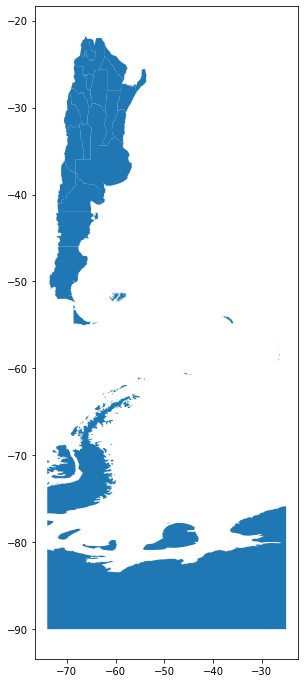

In [49]:
plt.figure(figsize=(7, 12))
provincias.plot(ax=plt.gca())

En principio se ven bien, dejémoslas así.